In [2]:
import os, io, json, zipfile
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image

class SH17ZipDataset(Dataset):
    def __init__(self, zip_path, transforms=None):
        assert os.path.isfile(zip_path), f"ZIP not found: {zip_path}"
        self.zf = zipfile.ZipFile(zip_path, 'r')
        all_files = self.zf.namelist()

        # 1) Collect annotation JSONs
        self.ann_files = sorted([f for f in all_files if f.lower().endswith('.json')])
        if not self.ann_files:
            raise RuntimeError("No .json annotation files found in the ZIP")

        # 2) Build a map: base filename (no ext) → zip path for each image file
        self.image_map = {}
        for f in all_files:
            ext = Path(f).suffix.lower()
            if ext in ('.jpg', '.jpeg', '.png'):
                base = Path(f).stem
                self.image_map[base] = f
        if not self.image_map:
            raise RuntimeError("No image files (.jpg/.png) found in the ZIP")

        self.transforms = transforms
        self.class_map = {"Helmet":1, "Gloves":2, "Glasses":3}

    def __len__(self):
        return len(self.ann_files)

    def __getitem__(self, idx):
        # --- Load JSON annotation ---
        ann_name = self.ann_files[idx]
        raw = self.zf.read(ann_name)
        data = json.loads(raw.decode('utf-8'))

        # --- Determine base filename ---
        base = Path(data.get('imagePath', '')).stem
        if not base:
            base = Path(ann_name).stem

        # --- Look up the image entry in the ZIP ---
        img_rel = self.image_map.get(base)
        if img_rel is None:
            raise FileNotFoundError(f"No image entry for base '{base}' in ZIP")
        img_bytes = self.zf.read(img_rel)
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # --- Parse boxes & labels from JSON ---
        boxes, labels = [], []
        shapes = data.get("objects", data.get("shapes", []))
        for obj in shapes:
            lbl = obj.get("label") or obj.get("class")
            if lbl not in self.class_map:
                continue
            pts = obj.get("points") or obj.get("bbox")
            if isinstance(pts, list) and pts and isinstance(pts[0], list):
                xs, ys = zip(*pts)
                box = [min(xs), min(ys), max(xs), max(ys)]
            elif isinstance(pts, list) and len(pts)==4:
                x,y,w,h = pts
                box = [x, y, x+w, y+h]
            else:
                continue
            boxes.append(box)
            labels.append(self.class_map[lbl])

        target = {
            "boxes":  torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        # --- Apply transforms & return ---
        if self.transforms:
            img = self.transforms(img)
        return img, target

def get_transform(train: bool = False):
    t = [T.ToTensor()]
    if train:
        t.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(t)

def collate_fn(batch):
    return tuple(zip(*batch))

if __name__ == "__main__":
    # ─── Update this to your ZIP path ─────────────
    zip_path = r"C:\Users\pcsal\ECGR4106\PPE.zip"

    # Instantiate & test
    ds = SH17ZipDataset(zip_path, transforms=get_transform(train=False))
    print(f"✅ Total samples: {len(ds)}")

    img, tgt = ds[0]
    print(" • Image shape:", img.shape)
    print(" • Boxes shape:", tgt["boxes"].shape)
    print(" • Labels shape:", tgt["labels"].shape)

    # DataLoader sanity check
    loader = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
    batch_imgs, batch_tgts = next(iter(loader))
    print(f"🚀 Loaded batch of {len(batch_imgs)} images")


✅ Total samples: 8099
 • Image shape: torch.Size([3, 3840, 5760])
 • Boxes shape: torch.Size([0])
 • Labels shape: torch.Size([0])
🚀 Loaded batch of 4 images


In [1]:
# train_lite640.py

import sys
# ─── strip stray VSCode/Jupyter flags ────────────────────────────────────────
_allowed = {
    '--data-dir': 1, '--batch-size': 1, '--img-size': 1,
    '--epochs': 1,   '--lr': 1,         '--workers': 1,
    '--save-path': 1,'--fine-tune': 0,
}
_clean = [sys.argv[0]]
_i = 1
while _i < len(sys.argv):
    _a = sys.argv[_i]
    if _a in _allowed:
        _clean.append(_a)
        if _allowed[_a] == 1 and _i + 1 < len(sys.argv):
            _clean.append(sys.argv[_i+1]); _i += 1
    _i += 1
sys.argv = _clean
# ────────────────────────────────────────────────────────────────────────────

import zipfile, argparse
from pathlib import Path

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

def extract_if_needed(zip_path: Path, extract_to: Path):
    if zip_path.exists() and not extract_to.exists():
        print(f"→ Extracting {zip_path.name} …")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_to)
        print("→ Extraction done.")

def find_dataset_root(extract_to: Path):
    if (extract_to/'train').is_dir():
        return extract_to
    for d in extract_to.iterdir():
        if d.is_dir() and (d/'train').is_dir():
            return d
    raise FileNotFoundError(f"No train/ under {extract_to}")

def get_loaders(root: Path, bs, img_sz, workers):
    train_tfms = transforms.Compose([
        transforms.Resize((img_sz, img_sz)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tfms = transforms.Compose([
        transforms.Resize((img_sz, img_sz)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    tr = datasets.ImageFolder(root/'train', transform=train_tfms)
    va = datasets.ImageFolder(root/'valid', transform=val_tfms)
    te = datasets.ImageFolder(root/'test',  transform=val_tfms)
    return (
        DataLoader(tr, batch_size=bs, shuffle=True,  num_workers=workers, pin_memory=True),
        DataLoader(va, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=True),
        DataLoader(te, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=True),
        tr.classes
    )

def build_model(nc):
    m = models.mobilenet_v2(pretrained=True)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, nc)
    return m

def train_one_epoch(m, dl, crit, opt, scaler, dev):
    m.train()
    loss_sum = correct = total = 0
    for x,y in dl:
        x,y = x.to(dev), y.to(dev)
        with torch.cuda.amp.autocast():
            out  = m(x)
            loss = crit(out,y)
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loss_sum += loss.item()*x.size(0)
        preds    = out.argmax(1)
        correct += (preds==y).sum().item()
        total   += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_one_epoch(m, dl, crit, dev):
    m.eval()
    loss_sum = correct = total = 0
    for x,y in dl:
        x,y = x.to(dev), y.to(dev)
        out  = m(x)
        loss = crit(out,y)
        loss_sum += loss.item()*x.size(0)
        preds    = out.argmax(1)
        correct += (preds==y).sum().item()
        total   += x.size(0)
    return loss_sum/total, correct/total

def main(args):
    data_dir   = Path(args.data_dir)
    zip_path   = data_dir/'Safety.zip'
    extract_to = data_dir/'Worksite-Safety-Monitoring-Dataset'

    extract_if_needed(zip_path, extract_to)
    root = find_dataset_root(extract_to)

    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", dev)

    tr_dl, va_dl, te_dl, classes = get_loaders(root, args.batch_size, args.img_size, args.workers)
    print("Classes:", classes)

    model     = build_model(len(classes)).to(dev)
    crit      = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
    scaler    = torch.cuda.amp.GradScaler()

    best_acc = 0
    for ep in range(1, args.epochs+1):
        tl, ta = train_one_epoch(model, tr_dl, crit, optimizer, scaler, dev)
        vl, va = eval_one_epoch(model, va_dl, crit, dev)
        print(f"[{ep}/{args.epochs}]  Train Acc={ta:.4f} |  Val Acc={va:.4f}")
        if va > best_acc:
            best_acc = va
            torch.save(model.state_dict(), args.save_path)
            print(f"→ Saved best model (Acc={va:.4f})")
        scheduler.step()

    tl, ta = eval_one_epoch(model, te_dl, crit, dev)
    print(f"[Test] Acc={ta:.4f}")

if __name__ == '__main__':
    p = argparse.ArgumentParser()
    p.add_argument('--data-dir',   type=str,   default=r"C:\Users\pcsal\ECGR4106")
    p.add_argument('--batch-size', type=int,   default=4)
    p.add_argument('--img-size',   type=int,   default=640)
    p.add_argument('--epochs',     type=int,   default=30)
    p.add_argument('--lr',         type=float, default=3e-4)
    p.add_argument('--workers',    type=int,   default=2)
    p.add_argument('--save-path',  type=str,   default="best_model.pth")
    p.add_argument('--fine-tune',  action='store_true')
    args = p.parse_args()
    main(args)


Device: cuda
Classes: ['safe', 'unsafe']


c:\Users\pcsal\miniforge3\envs\py_cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pcsal\miniforge3\envs\py_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\pcsal/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%
C:\Users\pcsal\AppData\Local\Temp\ipykernel_16016\2882248949.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', a

[1/30]  Train Acc=0.6272 |  Val Acc=0.7350
→ Saved best model (Acc=0.7350)
[2/30]  Train Acc=0.7006 |  Val Acc=0.8100
→ Saved best model (Acc=0.8100)
[3/30]  Train Acc=0.7432 |  Val Acc=0.8550
→ Saved best model (Acc=0.8550)
[4/30]  Train Acc=0.7889 |  Val Acc=0.8200
[5/30]  Train Acc=0.8099 |  Val Acc=0.8550
[6/30]  Train Acc=0.8290 |  Val Acc=0.8650
→ Saved best model (Acc=0.8650)
[7/30]  Train Acc=0.8512 |  Val Acc=0.8650
[8/30]  Train Acc=0.8802 |  Val Acc=0.7450
[9/30]  Train Acc=0.8951 |  Val Acc=0.8500
[10/30]  Train Acc=0.9210 |  Val Acc=0.8750
→ Saved best model (Acc=0.8750)
[11/30]  Train Acc=0.9247 |  Val Acc=0.9100
→ Saved best model (Acc=0.9100)
[12/30]  Train Acc=0.9444 |  Val Acc=0.8900
[13/30]  Train Acc=0.9512 |  Val Acc=0.8700
[14/30]  Train Acc=0.9648 |  Val Acc=0.8950
[15/30]  Train Acc=0.9679 |  Val Acc=0.8900
[16/30]  Train Acc=0.9778 |  Val Acc=0.8800
[17/30]  Train Acc=0.9765 |  Val Acc=0.9000
[18/30]  Train Acc=0.9870 |  Val Acc=0.8950
[19/30]  Train Acc=0.9877

Device: cuda
Classes: ['safe', 'unsafe']


C:\Users\pcsal\AppData\Local\Temp\ipykernel_16016\3973782883.py:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
C:\Users\pcsal\AppData\Local\Temp\ipykernel_16016\3973782883.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1/30]  Train L=0.6575 A=0.6327 |  Val L=0.6456 A=0.7600
→ Saved best model (Acc=0.7600)
[2/30]  Train L=0.5617 A=0.7117 |  Val L=0.8800 A=0.6250
[3/30]  Train L=0.5195 A=0.7525 |  Val L=0.4969 A=0.7850
→ Saved best model (Acc=0.7850)
[4/30]  Train L=0.4583 A=0.7932 |  Val L=0.6204 A=0.7600
[5/30]  Train L=0.4058 A=0.8160 |  Val L=0.6046 A=0.7200
[6/30]  Train L=0.4038 A=0.8148 |  Val L=0.3849 A=0.8350
→ Saved best model (Acc=0.8350)
[7/30]  Train L=0.3310 A=0.8722 |  Val L=0.3435 A=0.8850
→ Saved best model (Acc=0.8850)
[8/30]  Train L=0.3005 A=0.8765 |  Val L=0.3662 A=0.8400
[9/30]  Train L=0.2755 A=0.8963 |  Val L=0.3376 A=0.8600
[10/30]  Train L=0.2549 A=0.9025 |  Val L=0.3399 A=0.8650
[11/30]  Train L=0.2157 A=0.9154 |  Val L=0.3887 A=0.8950
→ Saved best model (Acc=0.8950)
[12/30]  Train L=0.1616 A=0.9426 |  Val L=0.3670 A=0.8550
[13/30]  Train L=0.1358 A=0.9543 |  Val L=0.3903 A=0.8850
[14/30]  Train L=0.1520 A=0.9475 |  Val L=0.3527 A=0.8750
[15/30]  Train L=0.1012 A=0.9648 |  V

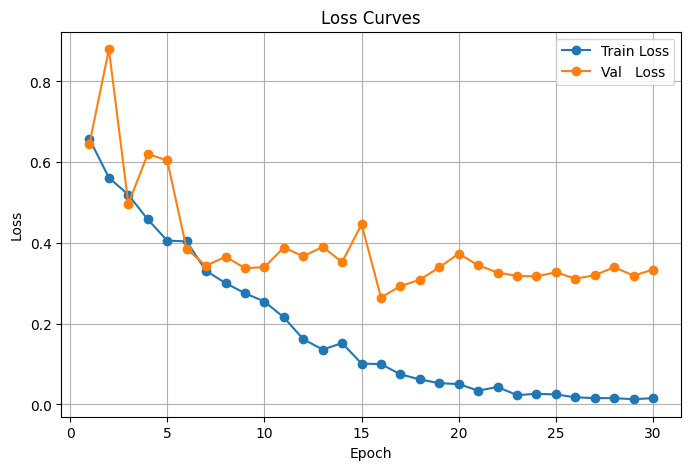

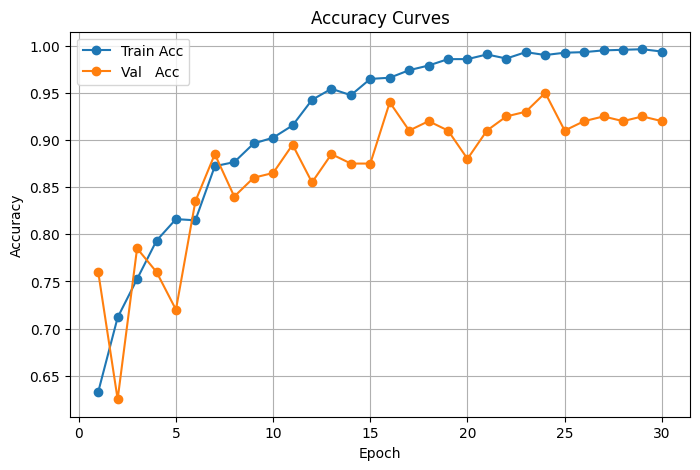

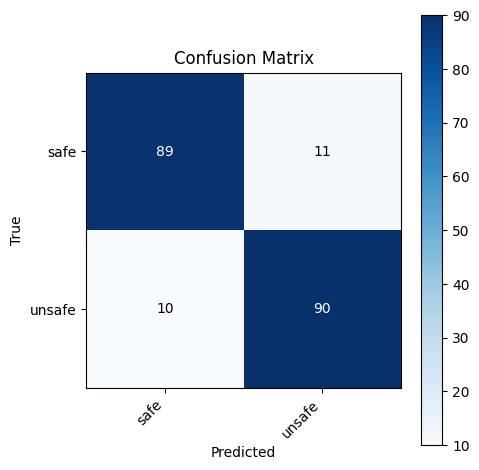

In [9]:
# train_lite640_with_plots.py

import sys
# ─── strip stray VSCode/Jupyter flags ────────────────────────────────────────
_allowed = {
    '--data-dir': 1, '--batch-size': 1, '--img-size': 1,
    '--epochs': 1,   '--lr': 1,         '--workers': 1,
    '--save-path': 1,'--fine-tune': 0,
}
_clean = [sys.argv[0]]
_i = 1
while _i < len(sys.argv):
    _a = sys.argv[_i]
    if _a in _allowed:
        _clean.append(_a)
        if _allowed[_a] == 1 and _i + 1 < len(sys.argv):
            _clean.append(sys.argv[_i+1]); _i += 1
    _i += 1
sys.argv = _clean
# ────────────────────────────────────────────────────────────────────────────

import zipfile
import argparse
from pathlib import Path

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def extract_if_needed(zip_path: Path, extract_to: Path):
    if zip_path.exists() and not extract_to.exists():
        print(f"→ Extracting {zip_path.name} …")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_to)
        print("→ Extraction done.")

def find_dataset_root(extract_to: Path):
    if (extract_to/'train').is_dir():
        return extract_to
    for d in extract_to.iterdir():
        if d.is_dir() and (d/'train').is_dir():
            return d
    raise FileNotFoundError(f"No train/ under {extract_to}")

def get_loaders(root: Path, bs, img_sz, workers):
    train_tfms = transforms.Compose([
        transforms.Resize((img_sz, img_sz)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tfms = transforms.Compose([
        transforms.Resize((img_sz, img_sz)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    tr = datasets.ImageFolder(root/'train', transform=train_tfms)
    va = datasets.ImageFolder(root/'valid', transform=val_tfms)
    te = datasets.ImageFolder(root/'test',  transform=val_tfms)
    return (
        DataLoader(tr, batch_size=bs, shuffle=True,  num_workers=workers, pin_memory=True),
        DataLoader(va, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=True),
        DataLoader(te, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=True),
        tr.classes
    )

def build_model(nc):
    m = models.mobilenet_v2(pretrained=True)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, nc)
    return m

def train_one_epoch(m, dl, crit, opt, scaler, dev):
    m.train()
    loss_sum = correct = total = 0
    for x,y in dl:
        x,y = x.to(dev), y.to(dev)
        with torch.cuda.amp.autocast():
            out  = m(x)
            loss = crit(out, y)
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loss_sum += loss.item() * x.size(0)
        preds    = out.argmax(1)
        correct += (preds==y).sum().item()
        total   += x.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_one_epoch(m, dl, crit, dev):
    m.eval()
    loss_sum = correct = total = 0
    for x,y in dl:
        x,y = x.to(dev), y.to(dev)
        out  = m(x)
        loss = crit(out, y)
        loss_sum += loss.item() * x.size(0)
        preds    = out.argmax(1)
        correct += (preds==y).sum().item()
        total   += x.size(0)
    return loss_sum/total, correct/total

def main(args):
    # Paths & extraction
    data_dir   = Path(args.data_dir)
    zip_path   = data_dir/'Safety.zip'
    extract_to = data_dir/'Worksite-Safety-Monitoring-Dataset'
    extract_if_needed(zip_path, extract_to)
    root = find_dataset_root(extract_to)

    # Device & data
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", dev)
    tr_dl, va_dl, te_dl, classes = get_loaders(root, args.batch_size, args.img_size, args.workers)
    print("Classes:", classes)

    # Model, loss, optimizer, scheduler, scaler
    model     = build_model(len(classes)).to(dev)
    crit      = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
    scaler    = torch.cuda.amp.GradScaler()

    # Metric containers
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    # Training loop
    best_acc = 0
    for ep in range(1, args.epochs+1):
        tl, ta = train_one_epoch(model, tr_dl, crit, optimizer, scaler, dev)
        vl, va = eval_one_epoch(model, va_dl,    crit, dev)

        # record metrics
        train_losses.append(tl)
        train_accs.append(ta)
        val_losses.append(vl)
        val_accs.append(va)

        print(f"[{ep}/{args.epochs}]  Train L={tl:.4f} A={ta:.4f} |  Val L={vl:.4f} A={va:.4f}")
        if va > best_acc:
            best_acc = va
            torch.save(model.state_dict(), args.save_path)
            print(f"→ Saved best model (Acc={va:.4f})")
        scheduler.step()

    # Final test eval
    tl, ta = eval_one_epoch(model, te_dl, crit, dev)
    print(f"[Test] Loss={tl:.4f} Acc={ta:.4f}")

    # ─── Plot training & validation curves ─────────────────────────────────────
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, '-o', label='Train Loss')
    plt.plot(epochs, val_losses,   '-o', label='Val   Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss Curves'); plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_accs, '-o', label='Train Acc')
    plt.plot(epochs, val_accs,   '-o', label='Val   Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy Curves'); plt.legend(); plt.grid(True)
    plt.show()

    # ─── Confusion matrix on test set ──────────────────────────────────────────
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in te_dl:
            imgs = imgs.to(dev)
            out  = model(imgs)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel='Predicted',
        ylabel='True',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j],
                    ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    p = argparse.ArgumentParser()
    p.add_argument('--data-dir',   type=str,   default=r"C:\Users\pcsal\ECGR4106")
    p.add_argument('--batch-size', type=int,   default=4)
    p.add_argument('--img-size',   type=int,   default=640)
    p.add_argument('--epochs',     type=int,   default=30)
    p.add_argument('--lr',         type=float, default=3e-4)
    p.add_argument('--workers',    type=int,   default=2)
    p.add_argument('--save-path',  type=str,   default="best_model.pth")
    p.add_argument('--fine-tune',  action='store_true')
    args = p.parse_args()
    main(args)
